In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from mfsetup import MF6model
from mfsetup.discretization import cellids_to_kij
from gisutils import df2shp
import mfexport

flopy is installed in /Users/aleaf/Documents/GitHub/flopy/flopy


In [2]:
m = MF6model.setup_from_yaml('pleasant_lgr_parent.yml')

loading configuration file pleasant_lgr_parent.yml...

Setting up plsnt_lgr_parent model from data in None


arguments to ModflowGwf:
modelname: plsnt_lgr_parent
version: mf6
simulation: sim_name = pleasant_lgr
sim_path = /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr
exe_name = mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = pleasant_lgr



list: /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/plsnt_lgr_parent.list
print_input: True
print_flows: False
save_flows: True
newtonoptions: ['under_relaxation']

other arguments:
list_filename_fmt: {}.list
options: {'newton': True,
 'newton_under_relaxation': True,
 'newtonoptions': ['under_relaxation'],
 'print_flows': False,
 'print_input': True,
 'save_flows': True}
packages: ['dis', 'ic', 'npf', 'oc', 'sto', 'rch', 'sfr', 'lak', 'obs', 'wel', 'ims']
hiKlakes_value: 

finished in 0.02s

wrote ./external/plsnt_lgr_parent_botm0.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_botm1.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_botm2.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_botm3.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_botm4.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_top.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain0.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain1.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain2.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain3.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain4.dat, took 0.00s

arguments to ModflowGwfdis:
nrow: 25
ncol: 25
nlay: 5
angrot: 0.0
delc: [200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0]
delr: [200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 

computing cell thicknesses...
finished in 0.02s

wrote ./external/plsnt_lgr_parent_idomain0.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain1.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain2.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain3.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain4.dat, took 0.00s

Setting up TDIS package...

arguments to ModflowTdis:
time_units: days
start_date_time: 2012-01-01
nper: 13
perioddata: [( 1., 1, 1. ) (31., 1, 1.5) (29., 1, 1.5) (31., 1, 1.5) (30., 1, 1.5)
 (31., 1, 1.5) (30., 1, 1.5) (31., 1, 1.5) (31., 1, 1.5) (30., 1, 1.5)
 (31., 1, 1.5) (30., 1, 1.5) (31., 1, 1.5)]

other arguments:
end_date_time: None


finished in 0.00s


Setting up IC package...
getting i, j locations...
finished in 0.00s

wrote ./external/plsnt_lgr_parent_strt0.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_strt1.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_strt2.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_strt3.dat, took 0


Time to create sfr dataset: 0.26s

running rasterstats.zonal_stats on buffered LineStrings...
finished in 0.05s


Smoothing elevations...
finished in 0.00s
writing /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/postproc/shps/plsnt_lgr_parent_sfr_cells.shp...
writing /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/postproc/shps/plsnt_lgr_parent_sfr_outlets.shp...
No non-zero values of flow to export!
writing /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/postproc/shps/plsnt_lgr_parent_sfr_lines.shp...
writing /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/postproc/shps/plsnt_lgr_parent_sfr_routing.shp...

arguments to ModflowGwfsfr:
save_flows: True
mover: True

other arguments:
budget_fileout: sfr_out.bin
stage_fileout: sfr_stage.bin
obs6_filein_fmt: {}.sfr.obs6
output_path: /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/postproc/shps
set_streambed_top_elevations_from_dem: True


converting r


arguments to ModflowGwfchd:
print_input: False
print_flows: False
save_flows: True

other arguments:


finished in 1.87s


Setting up DIS package...

arguments to ArraySourceData:
length_units: meters
filenames: {0: '/Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/dem40m.tif'}

other arguments:



arguments to ArraySourceData:
datatype: array2d
variable: top
dest_model: plsnt_lgr_inset model:
5 layer(s), 70 row(s), 80 column(s), 13 stress period(s)
Parent model: ./plsnt_lgr_parent
CRS: epsg:3070
(epsg: 3070)
Bounds: (554200.0, 557400.0, 389000.0, 391800.0)
Grid spacing: 40.00 meters
Packages:
vmin: -1e+30
vmax: 1e+30
resample_method: linear

other arguments:


reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/dem40m.tif...
finished in 0.03s
wrote ./external/plsnt_lgr_inset_top.dat, took 0.00s

arguments to ArraySourceData:
filenames: {1: '/Users/aleaf/Documents/GitHub/modflow-setup/examples/d

finished in 0.20s


arguments to MFsetupMixin.load_features:
filename: /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/all_lakes.shp
id_column: HYDROID
include_ids: [600059060]

other arguments:



arguments to MFsetupMixin.load_features:
filename: /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/all_lakes.shp
id_column: HYDROID
include_ids: [600059060]

other arguments:


reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/pleasant_bathymetry.tif...
finished in 0.03s
reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/pleasant_bathymetry.tif...
finished in 0.03s
wrote original/plsnt_lgr_inset_lakarr0.dat, took 0.00s
wrote original/plsnt_lgr_inset_lakarr1.dat, took 0.00s
wrote original/plsnt_lgr_inset_lakarr2.dat, took 0.00s
wrote original/plsnt_lgr_inset_lakarr3.dat, took 0.00s
wrote original/plsnt_lgr_inset_la



SFRmaker version 0.3.0.post9+g49c5203

Creating sfr dataset...

Creating grid class instance from flopy Grid instance...
grid class created in 0.12s

Model grid information
structured grid
nnodes: 5,600
nlay: 1
nrow: 70
ncol: 80
model length units: undefined
crs: epsg:3070
bounds: 554200.00, 389000.00, 557400.00, 391800.00
active area defined by: isfr array

plsnt_lgr_inset model:
5 layer(s), 70 row(s), 80 column(s), 13 stress period(s)
Parent model: ./plsnt_lgr_parent
CRS: epsg:3070
(epsg: 3070)
Bounds: (554200.0, 557400.0, 389000.0, 391800.0)
Grid spacing: 40.00 meters
Packages: dis ic npf sto rcha oc

reprojecting hydrography from
+proj=longlat +datum=NAD83 +no_defs
to
epsg:3070


Culling hydrography to active area...
simplification tolerance: 2000.00
starting lines: 2
remaining lines: 2
finished in 0.00s


Intersecting 2 flowlines with 5,600 grid cells...
Intersecting 2 features...
2
finished in 0.04s

Setting up reach data... (may take a few minutes for large grids)
finished in 

finished in 0.20s


reading /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/csls_sources_wu_pts.shp...
--> building dataframe... (may take a while for large shapefiles)
intersecting wells with model grid...
getting i, j locations...
finished in 0.00s

took 0.00s

computing cell thicknesses...
finished in 0.20s


Resampling pumping rates in /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/tables/master_wu.csv to model stress periods...
    wells with no data for a stress period will be assigned 0.0 pumping rates.
took 0.02s


arguments to ModflowGwfwel:
print_input: True
print_flows: True
save_flows: True
boundnames: True
stress_period_data: {0: rec.array([((4, 16, 24), 0., 'site24426'), ((4, 10, 67), 0., 'site6707')],
          dtype=[('cellid', 'O'), ('q', '<f8'), ('boundname', 'O')]),
 1: rec.array([((4, 16, 24), 0., 'site24426'), ((4, 10, 67), 0., 'site6707')],
          dtype=[('cellid', 'O'), ('q', '<f8'), ('boundna

In [3]:
m

plsnt_lgr_parent model:
5 layer(s), 25 row(s), 25 column(s), 13 stress period(s)
Parent model: /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/pleasant
CRS: epsg:3070
(epsg: 3070)
Bounds: (552800.0, 557800.0, 388200.0, 393200.0)
Grid spacing: 200.00 meters
Packages: dis ic npf sto rcha oc sfr wel_0 obs_0 chd_0

In [4]:
m.cfg.keys()

dict_keys(['simulation', 'model', 'parent', 'intermediate_data', 'postprocessing', 'setup_grid', 'dis', 'tdis', 'ic', 'npf', 'sto', 'rch', 'sfr', 'lak', 'mvr', 'wel', 'chd', 'oc', 'obs', 'ims', 'filename', 'ghb', 'maw', 'external_files', 'grid'])

In [5]:
m.cfg['dis']

defaultdict(dict,
            {'options': {'length_units': 'meters'},
             'dimensions': {'nlay': 5},
             'griddata': {'top': [{'filename': './external/plsnt_lgr_parent_top.dat'}],
              'botm': [{'filename': './external/plsnt_lgr_parent_botm0.dat'},
               {'filename': './external/plsnt_lgr_parent_botm1.dat'},
               {'filename': './external/plsnt_lgr_parent_botm2.dat'},
               {'filename': './external/plsnt_lgr_parent_botm3.dat'},
               {'filename': './external/plsnt_lgr_parent_botm4.dat'}],
              'idomain': [{'filename': './external/plsnt_lgr_parent_idomain0.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain1.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain2.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain3.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain4.dat'}]},
             'top_filename_fmt': 'top.dat',
             'botm_fi

In [6]:
m.inset

{'plsnt_lgr_inset': plsnt_lgr_inset model:
 5 layer(s), 70 row(s), 80 column(s), 13 stress period(s)
 Parent model: ./plsnt_lgr_parent
 CRS: epsg:3070
 (epsg: 3070)
 Bounds: (554200.0, 557400.0, 389000.0, 391800.0)
 Grid spacing: 40.00 meters
 Packages: dis ic npf sto rcha oc sfr lak obs_0 wel_0 obs_1}

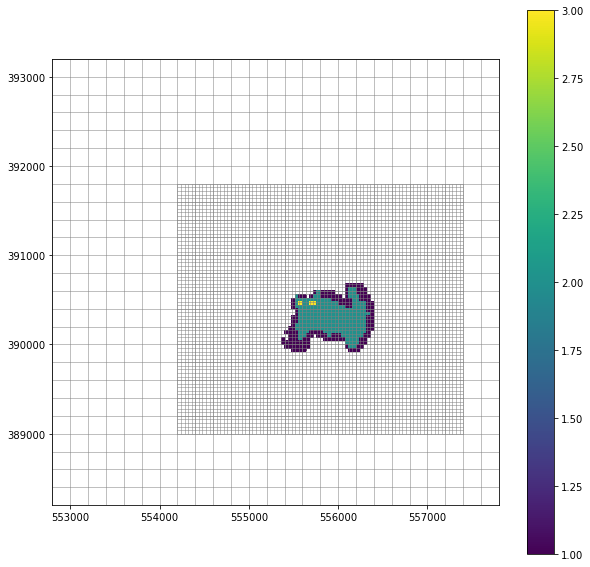

In [7]:
inset = m.inset['plsnt_lgr_inset']

l, r, b, t = m.modelgrid.extent
layer = 0

fig, ax = plt.subplots(figsize=(10, 10))
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

vconn = inset.lak.connectiondata.array[inset.lak.connectiondata.array['claktype'] == 'vertical']
k, i, j = cellids_to_kij(vconn['cellid'])
lakeconnections = np.zeros((inset.nrow, inset.ncol))
lakeconnections[i, j] = np.array(k)
lakeconnections = np.ma.masked_array(lakeconnections, mask=lakeconnections == 0)
qmi = inset_mv.plot_array(lakeconnections)

#inset_mv.plot_bc('LAK', color='navy')
#parent_mv.plot_bc('WEL_0', color='red')

lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)
ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
plt.colorbar(qmi)

In [8]:
m.write_input()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing mvr package pleasant_lgr.mvr...
  writing package pleasant_lgr.gwfgwf...
  writing model plsnt_lgr_parent...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha...
    writing package oc...
    writing package sfr...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package obs_0...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 235 based on size of stress_period_data
  writing model plsnt_lgr_inset...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha...
    writing package oc...
    writing p

In [9]:
# write the SFR package again using SFRmaker,
# because flopy doesn't check the packagedata against the idomain before writing
for model in m, m.inset['plsnt_lgr_inset']:
    if hasattr(model, 'sfr'):
        sfr_package_filename = os.path.join(model.model_ws, model.sfr.filename)
        model.sfrdata.write_package(sfr_package_filename,
                                    idomain=model.dis.idomain.array,
                                    version='mf6',
                                    options=['save_flows',
                                             'BUDGET FILEOUT {}.sfr.cbc'.format(model.name),
                                             'STAGE FILEOUT {}.sfr.stage.bin'.format(model.name),
                                             'mover'
                                               ]
                                    )

wrote ./plsnt_lgr_parent.sfr.obs
converting segment data to period data...
converting reach and segment data to package data...
wrote ./plsnt_lgr_parent.sfr
converting segment data to period data...
converting reach and segment data to package data...
wrote ./plsnt_lgr_inset.sfr


In [10]:
m.simulation.run_simulation()

FloPy is using the following  executable to run the model: /Users/aleaf/Documents/software/pymake_exes/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.0 12/12/2019

   MODFLOW 6 compiled Dec 13 2019 12:29:49 with IFORT compiler (ver. 19.0.5)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to 

(True, [])

In [11]:
os.getcwd()

'/Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr'

In [12]:
tmr_parent_headsobj = bf.HeadFile('../data/pleasant/pleasant.hds')
lgr_parent_headsobj = bf.HeadFile('plsnt_lgr_parent.hds')
lgr_inset_headsobj = bf.HeadFile('plsnt_lgr_inset.hds')

tmr_parent_hds = tmr_parent_headsobj.get_data(kstpkper=(4, 12))
lgr_parent_hds = lgr_parent_headsobj.get_data(kstpkper=(0, 12))
lgr_inset_hds = lgr_inset_headsobj.get_data(kstpkper=(0, 12))

lgr_parent_hds = np.ma.masked_array(lgr_parent_hds, mask=lgr_parent_hds == 1e30)
lgr_inset_hds = np.ma.masked_array(lgr_inset_hds, mask=lgr_inset_hds == 1e30)

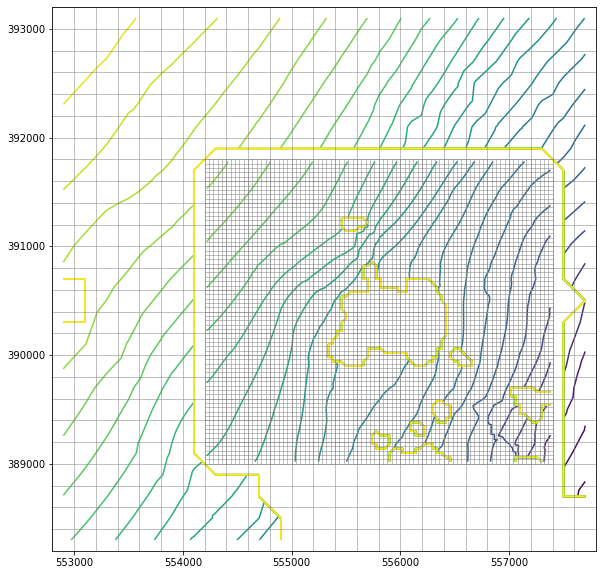

In [13]:
layer = 0

fig, ax = plt.subplots(figsize=(10, 10))
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

pctr = parent_mv.contour_array(lgr_parent_hds, levels=np.arange(290, 315))
ictr = inset_mv.contour_array(lgr_inset_hds, levels=np.arange(290, 315))
#qmp = parent_mv.plot_array(lgr_parent_hds)
#qmi = inset_mv.plot_array(lgr_inset_hds)

lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)
ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
#plt.colorbar(qmp)

In [14]:
for model in m, inset:
    mfexport.export(model, model.modelgrid, output_path='postproc/{}/'.format(model.name))


dis package...
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay4.tif
top:
wrote postproc/plsnt_lgr_parent/rasters/top.tif
botm:
wrote postproc/plsnt_lgr_parent/rasters/botm_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay4.tif
idomain:
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay4.tif

ic package...
strt:
wrote postproc/plsnt_lgr_parent/rasters/strt_

In [15]:
for model in m, inset:
    mfexport.summarize(model, output_path='postproc/{}/'.format(model.name))

summarizing plsnt_lgr_parent input...
summarizing plsnt_lgr_inset input...
skipped, not implemented yet


In [16]:
outpath='postproc/{}/shps'.format(inset.name)
if not os.path.isdir(outpath):
    os.makedirs(outpath)
connectiondata = pd.DataFrame(inset.lak.connectiondata.array)
k, i, j = cellids_to_kij(connectiondata['cellid'])
connectiondata['k'] = k
connectiondata['i'] = i
connectiondata['j'] = j
#connectiondata.drop('cellid', axis=1, inplace=True)
polygons = np.reshape(inset.modelgrid.polygons, (inset.modelgrid.nrow, inset.modelgrid.ncol))
connectiondata['geometry'] = polygons[i, j]
df2shp(connectiondata, os.path.join(outpath, 'lake_connections.shp'), epsg=3070)

creating shapely Polygons of grid cells...
finished in 0.05s

writing postproc/plsnt_lgr_inset/shps/lake_connections.shp...
